## Most of the method that are used to decide risk tolerance of any investor are based on qualitative judgement and manual effort (risk tolerance questionaire) but investors suffer from behavioral biases and are poor judges specially in stressed markets. Also involves quite manual stuff which cannot be automated. 

## We will try to develop an ML application to build a personality profile of the client of how they will deal different market scenarios

## This notebook will try to address these 2 problems :- 

1. Train a supervised regression model to predict risk tolernace of an investor
2. Build a robo advisor dashboard (free of any human dependency) 

In [2]:
#Independent variables will be demographic, financial and behavioural attriubutes
import pandas as pd
df = pd.read_excel('SCFP2009panel.xlsx')

In [14]:
import numpy as np

In [7]:
# Risky assets are MFs, stocks and bonds
df['Risky_asset07'] = df['NMMF07'] + df['STOCKS07'] + df['BOND07']
df['Risky_asset09'] = df['NMMF09'] + df['STOCKS09'] + df['BOND09']

In [8]:
# Risk free assets are Savings, CDs and liquids
df['Risky_free07'] = df['LIQ07'] + df['CDS07'] + df['SAVBND07'] + df['CASHLI07']
df['Risky_free09'] = df['LIQ09'] + df['CDS09'] + df['SAVBND09'] + df['CASHLI09']

In [11]:
# Ratio of risky assests to total assests is riks tolerance
df['RT07'] = df['Risky_asset07']/(df['Risky_asset07']+df['Risky_free07'])

In [12]:
# stock index for normalising risky assets in 209
Average_SP500_2007=1478
Average_SP500_2009=948

In [13]:
df['RT09'] = (df['Risky_asset09']/(df['Risky_asset09']+df['Risky_free09']))*(Average_SP500_2009/Average_SP500_2007)

In [15]:
# absolute percentage change of RT
df['PerChange'] = np.abs(df['RT09']/df['RT07'] - 1) #if RT07 is zero, this will give error

In [16]:
# drop any row that contains NA
print(df.shape)
df = df.dropna(axis=0)
print(df.shape)

(19285, 522)
(9230, 522)


In [19]:
print(df.shape)
df = df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]
print(df.shape)

(9230, 522)
(7956, 522)


In [39]:
# Final dataframe created
import seaborn as sns
import matplotlib.pyplot as plt

In [32]:
import warnings
warnings.filterwarnings('ignore')

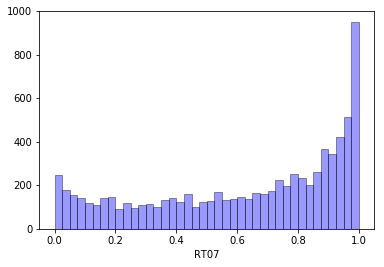

In [23]:
sns.distplot(df['RT07'], color='blue', hist=True, bins = 40, kde=False, hist_kws={'edgecolor' : 'black'})

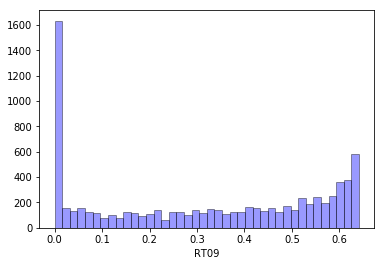

In [25]:
sns.distplot(df['RT09'], kde=False, hist=True, bins=40, color='blue', hist_kws={'edgecolor' : 'black'})

We can observer the risk tolerance shifted from close to 1 in 2007 to close to 0 in 2009 (market effect of 2008, behaviour reversed after the crisis)

Intelligent investors are those whose behaviour do not change by more than 10% (both sides)

In [33]:
df_int = df[df['PerChange'] <= 0.1]
df_int['true_risk_tolerance'] = (df_int['RT07'] + df_int['RT09']) / 2

In [34]:
# true_risk_tolerance is the predicted variable for our analysis, drop other variables
df_int = df_int.drop(labels = ['RT07', 'RT09', 'PerChange'], axis=1)

## Variables Selection

**Predictor Variable :** Age, Martial status, education, occupation, kids, spending habits ( expense > earning or vice versa), net worth, income vategory, Risk (1 being highest, 4 being lowest)

**Predicted Variable :** True risk tolerance 

In [37]:
keep_list2 = ['AGE07','EDCL07','MARRIED07','KIDS07','OCCAT107','INCOME07','RISK07','NETWORTH07','true_risk_tolerance']
drop_list = [i for i in df_int.columns if i not in keep_list2]

In [38]:
print(df_int.shape)
df_int = df_int.drop(labels=drop_list, axis =1)
print(df_int.shape)

(355, 520)
(355, 9)


#### Always remember that if you have finding correlation matrix of a dataset, it is better to show these numbers using a heat map

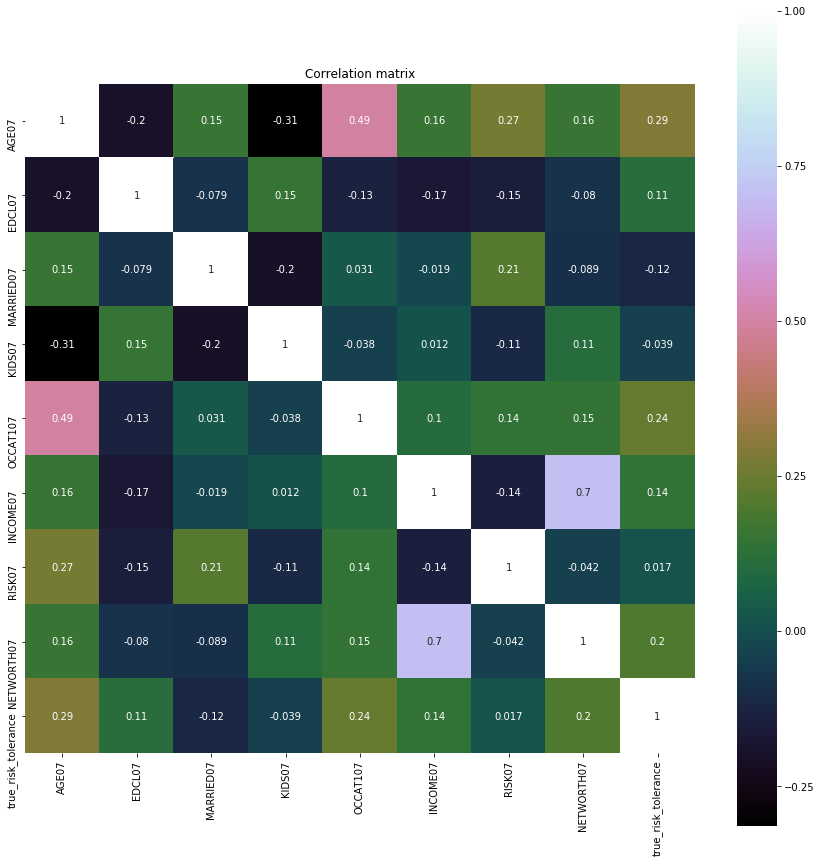

In [49]:
correlation = df_int.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation matrix')
sns.heatmap(correlation, vmax=1, cmap='cubehelix', square=True, annot=True)

We will use above dataset for our analysis. Although data is as of 2007 but true risk tolerance is average of 2007 and 2009

In [53]:
Y = df_int['true_risk_tolerance']
X = df_int.loc[:, df_int.columns != 'true_risk_tolerance']

In [54]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold

In [60]:
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

In [62]:
from sklearn.metrics import mean_squared_error

In [56]:
validation_size = 0.2
seed =10

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed)

## Remember when we have time series data, we should be very careful with respect to how do we split our data. We should not use train test split because it split randomly.

In [80]:
num_folds = 10
scoring = "r2"  # using r square as evaluation metric
models = {
    'LR': LinearRegression(),
    'LASSO': Lasso(),
    'EN': ElasticNet(),
    'DT': DecisionTreeRegressor(),  #Classifiation and Regression Tree
    'SVR': SVR(),
    'KNR': KNeighborsRegressor(),
    'RFR': RandomForestRegressor(),
    'GFR': GradientBoostingRegressor(),
    'ETR': ExtraTreesRegressor(),
    'ADR': AdaBoostRegressor(),
}

In [81]:
names = []
cv_scores = []
training_error = []
test_error = []
for name, model in models.items():
    names.append(name)
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_score = -1*cross_val_score(model, x_train, y_train, cv=kfold, scoring=scoring)
    cv_scores.append(cv_score)
    md = model.fit(x_train, y_train)
    training_error.append(mean_squared_error(md.predict(x_train), y_train))
    test_error.append(mean_squared_error(md.predict(x_test), y_test))

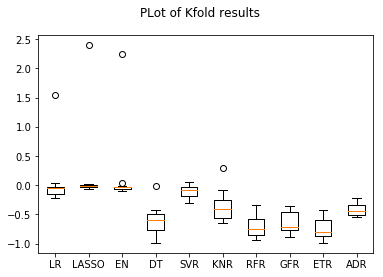

In [82]:
# Plotting cross validation set errors
fig = plt.figure()
fig.suptitle("PLot of Kfold results")
ax = fig.add_subplot(111)
plt.boxplot(cv_scores)
ax.set_xticklabels(names)
plt.show()

Non linear models perform better than the linear models. We have chosen RFR for further analysis. 

## Model tuning and Grid Search

In [83]:
# one of the most important parameter in RFR is number of trees
param_grid = {'n_estimators':[50, 100, 150, 200, 250, 300, 350, 400]}
model = RandomForestRegressor()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid_results = GridSearchCV(estimator=model, scoring=scoring, param_grid=param_grid, cv=kfold)
grid = grid_results.fit(x_train, y_train)

In [88]:
print(f'Best score is {grid.best_score_} and best parameters is {grid.best_params_}')
means = grid.cv_results_['mean_test_score']
std = grid.cv_results_['std_test_score']
parameter_score = grid.cv_results_['params']

Best score is 0.7309444381550412 and best parameters is {'n_estimators': 100}


In [91]:
from sklearn.metrics import r2_score

In [94]:
final_model = RandomForestRegressor(n_estimators=100)
f_m = final_model.fit(x_train, y_train)
training_score = r2_score(f_m.predict(x_train), y_train)
r_score = r2_score(f_m.predict(x_test), y_test)
print(f"Training error is {training_score}")
print(f"Test error is {r_score}")

Training error is 0.9570408265665072
Test error is 0.7916296469727135


### Features importance

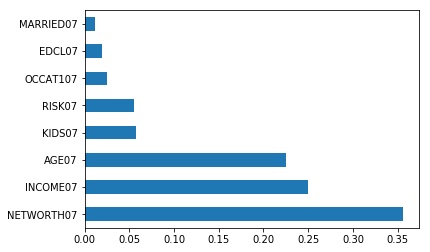

In [101]:
feat_importances = pd.Series(f_m.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')

### Save model for later use on new data

In [102]:
from pickle import dump, load

In [106]:
file_name = 'rfr_model_for_risk_toleance.sav'
dump(f_m, open(file_name, 'wb'))

In [107]:
# load model from disk
loaded_model = load(open(file_name, 'rb'))

In [109]:
training_score = r2_score(loaded_model.predict(x_train), y_train)
r_score = r2_score(loaded_model.predict(x_test), y_test)
print(f"Training error is {training_score}")
print(f"Test error is {r_score}")

Training error is 0.9570408265665072
Test error is 0.7916296469727135
